### SBU CSE 352 - HW 1 -  Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

---

All student names in group: James Nanas, Zachary Lowinger, Stanley Yu

I understand that my submission needs to be my own group's work: JN, ZL, SY

I understand that ChatGPT / Copilot / other AI tools are not allowed: JN, ZL, SY

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [19]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [20]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'south'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [21]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [22]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: suck
step 2 - action: south
step 3 - action: south
step 4 - action: north
step 5 - action: east
step 6 - action: north
step 7 - action: suck
step 8 - action: south
step 9 - action: west
step 10 - action: west
step 11 - action: west
step 12 - action: south
step 13 - action: east
step 14 - action: east
step 15 - action: south
step 16 - action: south
step 17 - action: north
step 18 - action: east
step 19 - action: west


2

# Tasks

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [23]:
import numpy as np


# A more realistic simulation environment that supplies the agent with its percepts, following the PEAS description.
def real_environment(agent, max_steps = 20, room_size = 5, verbose = True):
    num_actions = 0  # Number of actions it takes for the agent to complete the task.
    p = 0.2  # Probability of a square being dirty.


    # Keeps track of all of the squares of the room if they're clean (False) or dirty (True).
    room = np.array([np.random.choice([False, True], size = room_size, p = [1-p, p]) for _ in range(room_size)])

    # Initially randomize the location of the agent with (row, column).
    agent_location = (np.random.choice(range(room_size)), np.random.choice(range(room_size)))
    display_room_and_agent(verbose, room, agent_location, -1)

    # Loop through the agent function repeatedly until max steps have been reached or all dirty squares are cleaned.
    for i in range(max_steps):
        # First check if the room is completely clear. If so, then break.
        if is_completely_clean(room, room_size, room_size):
            if verbose: print("The room is fully clean.")
            break

        # Bumpers indicate if the agent is in a corner
        # (i.e. northwest would have the agent location be (0,0), making "north" and "west" true).
        bumpers = {"north" : agent_location[0] == 0, "south": agent_location[0] == room_size-1,
                   "west": agent_location[1] == 0, "east": agent_location[1] == room_size-1}
        dirty = room[agent_location[0], agent_location[1]]
        # Calls the agent function repeatedly with the sensor inputs bumpers and if the current square is dirty.
        action = agent(bumpers, dirty)
        if (verbose): print("Step", i , "- Action:", action)
        num_actions += 1

        # Reacts to the agent's actions here.
        if (action == "suck"):
            room[agent_location[0], agent_location[1]] = False
        else:
            if action == "north" and not bumpers[action]:
                agent_location = (agent_location[0]-1, agent_location[1])
            if action == "south" and not bumpers[action]:
                agent_location = (agent_location[0]+1, agent_location[1])
            if action == "west" and not bumpers[action]:
                agent_location = (agent_location[0], agent_location[1]-1)
            if action == "east" and not bumpers[action]:
                agent_location = (agent_location[0], agent_location[1]+1)

        display_room_and_agent(verbose, room, agent_location, i)
        if (verbose) and (num_actions == max_steps): print("Max steps reached.")
    if (verbose): print("Finished!")
    return num_actions


# Helper functions #
# Checks if the entire room is clean given the dimensions. Returns true if fully clean, else false.
def is_completely_clean(room, rows, cols):
    return all(not room[row][col] for row in range(rows) for col in range(cols))

# If verbose mode is True, then this displays the current state of the room and the agent's location after step i.
# If this is an initial state, then i = -1
def display_room_and_agent(verbose, room, agent_location, i):
    if (verbose):
        if i < 0:
            print(f"Initial environment:\n{room}")
            print(f"Initial agent location: {agent_location}")
            print(f"----------------------------------------")
        else: 
            print(f"Environment after step {i}:\n{room}")
            print(f"Agent location: {agent_location}")
            print(f"----------------------------------------")

In [24]:
# Test case from the simple environment example
real_environment(simple_randomized_agent, max_steps=100000)

Initial environment:
[[False False False False False]
 [ True False False False False]
 [False  True False False  True]
 [ True False False False  True]
 [ True False  True False False]]
Initial agent location: (3, 0)
----------------------------------------
Step 0 - Action: north
Environment after step 0:
[[False False False False False]
 [ True False False False False]
 [False  True False False  True]
 [ True False False False  True]
 [ True False  True False False]]
Agent location: (2, 0)
----------------------------------------
Step 1 - Action: south
Environment after step 1:
[[False False False False False]
 [ True False False False False]
 [False  True False False  True]
 [ True False False False  True]
 [ True False  True False False]]
Agent location: (3, 0)
----------------------------------------
Step 2 - Action: suck
Environment after step 2:
[[False False False False False]
 [ True False False False False]
 [False  True False False  True]
 [False False False False  True]
 [ 

495

### Documentation and Discussion
In my implementation of the simulation environment (the function *real_environment*), before I go into the loop, I initialize $p=0.2$ as well as randomized each of the squares in a 2-dimensional array to see if a square is clean (represented by False) or dirty (True). I also initialize the agent location via a tuple of the row number and then the column number, which can be from 0 up to $n-1$.

Inside of the for loop for looping the agent function until the max steps have been reach, I first check if the room is completely clear, and if it is, then break. The reason for this is to make sure the agent function stops running after the task is complete, and to also accurately track how many steps it took to completely clean the room. The *bumpers* and *dirty* variables are like from the simple environment example as the sensor inputs for the agent. After the action has been decided, the environment reacts to the action according, including making a square clean from the "suck" action (turn the square to False) and moving the agent in one of the directions. After the task is done or the max number of steps have been reached, the number of actions is returned.

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [25]:
import numpy as np


# Simple reflex agent for vacuum cleaning. Reacts to the bumper sensors and the dirt sensor, 
# but still moves in a random direction when able to. 
def simple_reflex_agent(bumpers, dirty):
    # Initialize actions
    actions = ["north", "east", "west", "south", "suck"]

    # If the current square is dirty, then return the action "suck", else remove the "suck" action from "actions".
    if (dirty):
        return actions[4]
    actions.remove("suck")

    # If the agent is in any of the 4 corners, remove the action that moves into said direction to prevent bumping into a wall.
    if (bumpers["north"]): actions.remove("north")
    if (bumpers["south"]): actions.remove("south")
    if (bumpers["west"]): actions.remove("west")
    if (bumpers["east"]): actions.remove("east")
    
    # Then, return a random direction to move in after removing the directions that have bumpers.
    return np.random.choice(actions)

In [26]:
# Test case for simple reflex agent with my simulation environment
real_environment(simple_reflex_agent, max_steps=100000)

Initial environment:
[[False False False  True False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [False  True  True False False]]
Initial agent location: (1, 4)
----------------------------------------
Step 0 - Action: south
Environment after step 0:
[[False False False  True False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [False  True  True False False]]
Agent location: (2, 4)
----------------------------------------
Step 1 - Action: south
Environment after step 1:
[[False False False  True False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [False  True  True False False]]
Agent location: (3, 4)
----------------------------------------
Step 2 - Action: west
Environment after step 2:
[[False False False  True False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [F

107

### Documentation and Discussion
My implementation for the simple reflex agent is not too much different from the randomized agent. The main difference is that it utilizes the sensors to be able to clean a square when it's on a dirty square as well as it not bumping into any walls when it detects that it's in a corner. If the agent is in any of the corners, those actions are removed from the list (as well as the "suck" action if the current square is not dirty), leaving the agent with a select few actions to choose from. However, ultimately the agent will still pick random actions, except it doesn't bump into a wall nor has a change to ignore dirty squares.

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

### My Description of Agent State and Implementation
In my model-based reflex agent, in order to keep track of the location, the agent would have to first move all the way to a corner since the only sensors it has for location are the bumpers. In terms of which corner, for the purposes of this agent, let's just say it moves to the northwest corner no matter what. However, if there's a dirty square on the way to the corner, the agent will still clean it.

Once the agent comes to the northwest corner, it will then move from the west side of the corner to the east and then move one south, and then move back from the east corner to the west, and repeat until it fully searches the entire room. Of course, on the way if there's a dirty square, the agent will clean it before checking the next square systematically.

Additionally, if the agent has finished cleaning, there will be a reset function to set up the agent once again.

In [27]:
# My model reflex agent as a class which will store the state of the starting corner it's in as well as if it's "primed" to start searching
class Model_Reflex_Agent:
    def __init__(self) -> None:
        self.start_corner = "west"
        self.primed = False


    # Used for resetting the agent after finishing the task
    def reset(self):
        self.start_corner = "west"
        self.primed = False

    
    # This function will be used for the input for the simulation environment
    def act(self, bumpers, dirty):
        # Initialize actions
        actions = ["north", "east", "south", "west", "suck"]

        # If the agent is not primed, then focus on moving to the northwest corner (and clean if the square is dirty).
        # When the agent is in the northwest corner, set "primed" to True.
        if not self.primed:
            if dirty: return actions[4]
            if not bumpers["north"]: return actions[0]
            if not bumpers["west"]: return actions[3]
            self.primed = True
        
        # If the agent is primed, start moving from west to east 
        # (south and then east to west if the agent makes it to the east corner)
        if self.start_corner == "west": 
            if dirty: return actions[4]
            if not bumpers["east"]: return actions[1]
            self.start_corner = "east"
            return actions[2]
        
        if dirty: return actions[4]
        if not bumpers["west"]: return actions[3]
        self.start_corner = "west"
        return actions[2]

In [28]:
# Test case for simple reflex agent with my simulation environment
model_reflex_agent = Model_Reflex_Agent()
real_environment(model_reflex_agent.act, max_steps=100000)
model_reflex_agent.reset()

Initial environment:
[[ True False False  True False]
 [False False False False False]
 [False False False  True False]
 [False  True False False False]
 [False  True  True False  True]]
Initial agent location: (2, 3)
----------------------------------------
Step 0 - Action: suck
Environment after step 0:
[[ True False False  True False]
 [False False False False False]
 [False False False False False]
 [False  True False False False]
 [False  True  True False  True]]
Agent location: (2, 3)
----------------------------------------
Step 1 - Action: north
Environment after step 1:
[[ True False False  True False]
 [False False False False False]
 [False False False False False]
 [False  True False False False]
 [False  True  True False  True]]
Agent location: (1, 3)
----------------------------------------
Step 2 - Action: north
Environment after step 2:
[[ True False False  True False]
 [False False False False False]
 [False False False False False]
 [False  True False False False]
 [F

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [29]:
# Simulates testing the given agent with the room size and the number of runs (default is 100)
def execute_simulation_test(agent, room_size, num_runs = 100):
    # If this agent is a model reflex agent, then for every test run its internal states should be reset.
    if isinstance(agent, Model_Reflex_Agent):
        test_results = []
        for _ in range(num_runs):
            agent.reset()
            test_result = real_environment(agent.act, max_steps=100000, room_size=room_size, verbose=False)
            test_results.append(test_result)
        return test_results

    return [real_environment(agent, max_steps=100000, room_size=room_size, verbose=False) for _ in range(num_runs)]

In [30]:
# Execute the tests for the randomized agent
random_agent_size_5_test_results = execute_simulation_test(simple_randomized_agent, room_size=5)
random_agent_size_10_test_results = execute_simulation_test(simple_randomized_agent, room_size=10)
random_agent_size_100_test_results = execute_simulation_test(simple_randomized_agent, room_size=100)

In [31]:
# Execute the tests for the simple reflex agent
simple_reflex_agent_size_5_test_results = execute_simulation_test(simple_reflex_agent, room_size=5)
simple_reflex_agent_size_10_test_results = execute_simulation_test(simple_reflex_agent, room_size=10)
simple_reflex_agent_size_100_test_results = execute_simulation_test(simple_reflex_agent, room_size=100)

In [32]:
# Execute the tests for the model-based reflex agent
model_reflex_agent_size_5_test_results = execute_simulation_test(model_reflex_agent, room_size=5)
model_reflex_agent_size_10_test_results = execute_simulation_test(model_reflex_agent, room_size=10)
model_reflex_agent_size_100_test_results = execute_simulation_test(model_reflex_agent, room_size=100)

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | | | |
| 10x10   | | | |
| 100x100 | | | |

Add charts to compare the performance of the different agents.

           Randomized Agent  Simple Reflex Agent  Model-based Reflex Agent
5 x 5                464.29               110.78                     28.40
10 x 10             2979.37               935.63                    123.73
100 x 100         100000.00            100000.00                  12104.33


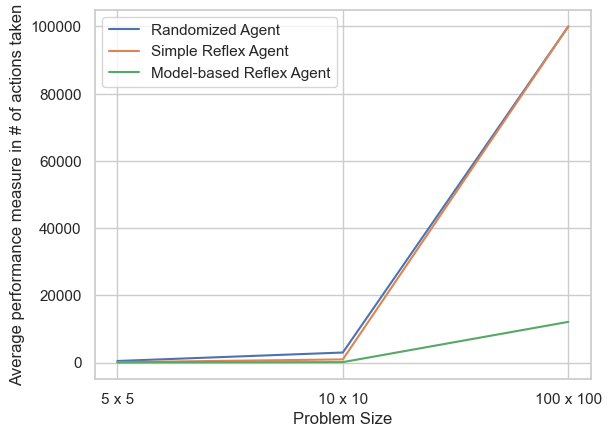

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Take the average of each of the test results by the problem size of n x n
average_size_5_results = [np.average(random_agent_size_5_test_results),
                          np.average(simple_reflex_agent_size_5_test_results),
                          np.average(model_reflex_agent_size_5_test_results)]
average_size_10_results = [np.average(random_agent_size_10_test_results),
                           np.average(simple_reflex_agent_size_10_test_results),
                           np.average(model_reflex_agent_size_10_test_results)]
average_size_100_results = [np.average(random_agent_size_100_test_results),
                            np.average(simple_reflex_agent_size_100_test_results),
                            np.average(model_reflex_agent_size_100_test_results)]

# Display the table for each of the agents' average performance measures depending on the size n.
data_display = np.array([average_size_5_results, average_size_10_results, average_size_100_results])
agents_list = ["Randomized Agent", "Simple Reflex Agent", "Model-based Reflex Agent"]
size_list = ["5 x 5", "10 x 10", "100 x 100"]
simulationData = pd.DataFrame(data_display, size_list, agents_list)
print(simulationData)

# Display the line chart for each of the agents' average performance measures depending on the size n.
sns.set(style="whitegrid")
plt.plot(size_list, [average_size_5_results[0], average_size_10_results[0], average_size_100_results[0]], label="Randomized Agent")
plt.plot(size_list, [average_size_5_results[1], average_size_10_results[1], average_size_100_results[1]], label="Simple Reflex Agent")
plt.plot(size_list, [average_size_5_results[2], average_size_10_results[2], average_size_100_results[2]], label="Model-based Reflex Agent")
plt.xlabel("Problem Size")
plt.ylabel("Average performance measure in # of actions taken")
plt.legend()
plt.show()

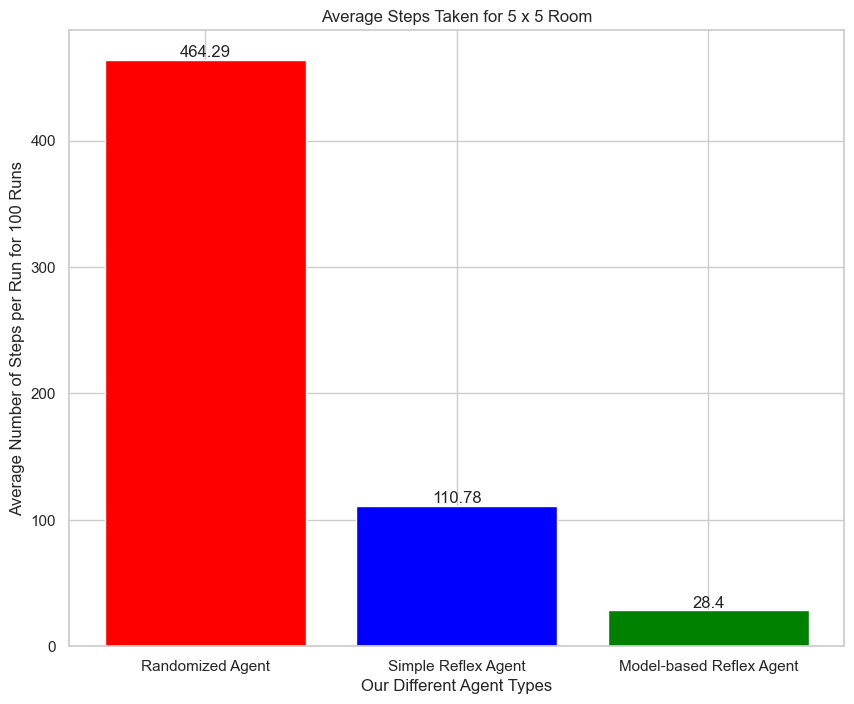

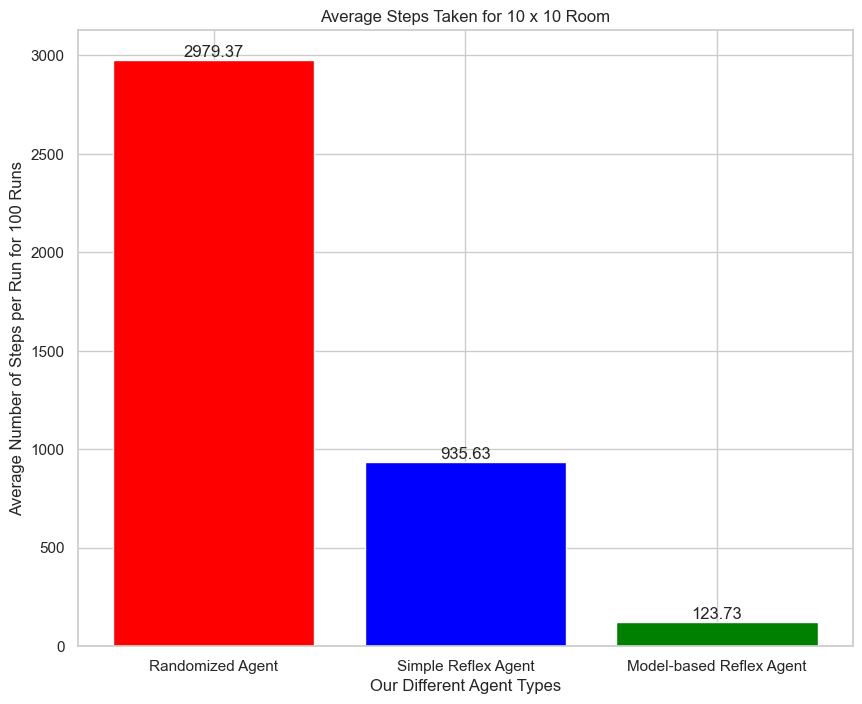

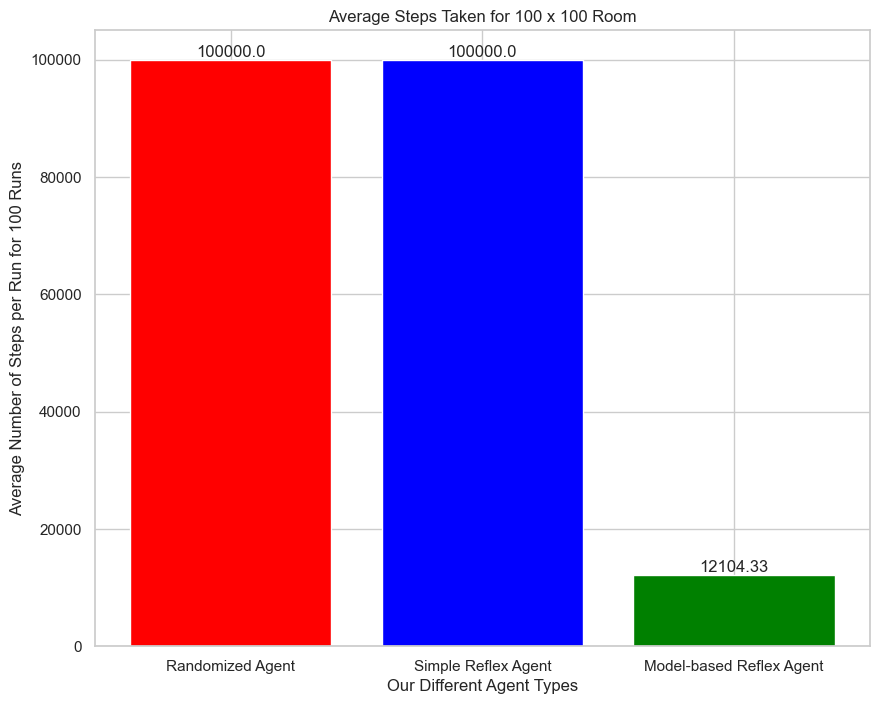

In [41]:
agentColors = ['red', 'blue', 'green']

for roomSize in size_list:
    plt.figure(figsize=(10, 8)) #Need to set before creating any chart or wont change 

    for i, agentType in enumerate(agents_list):
        averageSteps = simulationData[agentType][roomSize] #Extract steps from df
        plt.bar(agentType, averageSteps, color=agentColors[i]) #Set bar for steps and color
        plt.text(agentType, averageSteps, averageSteps, va='bottom',ha='center',) #Display total on top of bar

    plt.xlabel('Our Different Agent Types')
    plt.ylabel(f'Average Number of Steps per Run for 100 Runs')
    plt.title(f'Average Steps Taken for {roomSize} Room')
    plt.show() #Display a chart 

### Discussion of Performance Measure Results
The performance between the agents has very clear differences, especially with the model-based reflex agent compared to the other two agents tested. Overall, though, the model-based reflex agent had the best performance with the lowest average number of actions taken to complete cleaning a room of various sizes while the simple reflex agent did the second best, and the randomized agent did the worst. Interestingly both the randomized agent and simple reflex agent both took the max amount of steps taken of $100000$ when tasked with cleaning a room that's size $100 \times 100$. While the simple reflex agent is slightly better than the completely randomized agent, it still moved around randomly, not covering the most amount of squares efficiently in this experiemnt. Meanwhile, keeping track of the state of where the model-based reflex agent is what made the huge difference between it and the other two agents.

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

### Answer
Let's start off with my implementation of the simple reflex agent. If it is put into a rectangular room with unknown size, it would pretty much do about as well as in the simulation study since as the size of the room increases, the simple reflex agent will do worse and worse. That'll be the same case with the cleaning area having an irregular shape as well as if the room contains obstacles, as the simple reflex agent will be able to detect these things using the bumper sensors, but the performance would perhaps be similar to the regular use-case.

As for the model-based reflex agent, it can do well if it is put into a rectangular room with unknown size since it will still be able to detect when it has reached the northwest corner of the room and then systematically scan the entire room from the northwest corner to the southeast corner. However, if the cleaning area has an irregular shape and/or if the room contains obstacles, the model-based reflex agent I implemented would not work as well, as it will miss specific spots because it does not account for those two scenarios. The way my version of the model-based reflex agent would only be able to handle rectangular rooms.



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
